# Sentiment Analysis P3

In this notebook, you will learn how to build a deep LSTM network and how to insert a fixed pre-trained embedding layer in Keras

<img src="resources/pipeline.png" width="800px">

喜欢使用RNN的原因是因为可以保留word 的sequence

## Still Emoji

In [1]:
# import 
import numpy as np
import utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Embedding
from tensorflow.keras.preprocessing import sequence

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'


np.random.seed(1)

In [2]:
train_x, test_x, train_y, test_y = utils.load_emoji()

**Load pretrained word embeddings**

2 dictionaries are loaded:

- `word_to_index`: map a word to its index in the vocabulary
    - Example:  `'word' -> 1234`

- `word_to_vec_map`: map a word to its embedding
    - Example: `'word' -> [0.1, 0.2, ..., 0.45]`

When adding a custom embedding layer in Keras, we can only load the pretrained embedding as a big matrix instead of a dictionary. An index will help us locate the entry for a given word.

### Word Embeddings & One Hot

In [3]:
word_to_index, word_to_vec_map = utils.load_glove_vecs()

data already available, skip downloading.
loading glove... this may take a while...
glove loaded successfully.


In [4]:
len(word_to_index)  # This is the number of pre-trained words

400000

In [5]:
utils.sentences_to_indices?

In [6]:
# Convert word to the index in vocabulary
utils.sentences_to_indices(
    np.array(["i like it", "i hate it"]),  # array of test sentences
    word_to_index, 
    max_len = 5) # 如果超过max_len,就需要做截断了

array([[185457., 222471., 193716.,      0.,      0.],
       [185457., 174339., 193716.,      0.,      0.]])

In [7]:
maxlen = max([len(x.split()) for x in train_x])
print('max number of words in a sentence:', maxlen)# find the max length in the training data

max number of words in a sentence: 10


In [8]:
# Convert training/testing features into index list
train_x = utils.sentences_to_indices(train_x, word_to_index, maxlen)
test_x = utils.sentences_to_indices(test_x, word_to_index, maxlen)

# Convert training/testing labels into one hot array
train_y = utils.convert_to_one_hot(train_y, C = 5)
test_y = utils.convert_to_one_hot(test_y, C = 5)

In [9]:
# Check to make sure the shape looks good
assert train_x.shape == (132, maxlen)
assert train_y.shape == (132, 5)

### Embedding Layer

We need to build a embedding matrix where each row represent a word vector.

In [10]:
def pretrained_embedding_layer(word_to_index, word_to_vec_map):
    """
    Build and return a Keras Embedding Layer given word_to_vec mapping and word_to_index mapping
    
    Args:
        word_to_index (dict[str->int]): map from a word to its index in vocabulary
        word_to_vec_map (dict[str->np.ndarray]): map from a word to a vector with shape (N,) where N is the length of a word vector (50 in our case)

    Return:
        Keras.layers.Embedding: Embedding layer
    """
    
    # Keras requires vocab length start from index 1
    vocab_len = len(word_to_index) + 1  # 0 是预留给 out of vocabulary 的单词
    emb_dim = list(word_to_vec_map.values())[0].shape[0]
    
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    return Embedding(
        input_dim=vocab_len, 
        output_dim=emb_dim, 
        trainable=False,  # Indicating this is a pre-trained embedding. False: 不希望embedding layer一起训练
        weights=[emb_matrix])

In [11]:
#.add(pretrained_embedding_layer(word_to_index, word_to_vec_map))#how to use

For more information on how to define a pre-trained embedding layer in Keras, please refer to [this post](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html).

### Build the Model

<img src="resources/deep_lstm.png" style="width:700px;height:400px;"> <br>
<caption><center> A 2-layer LSTM sequence classifier. </center></caption>

### 如何理解：
- 第一层 N-N type, DROPOUT 防止overfitting
- 第二层 是N-1 type

In [12]:
def build_emoji_model(input_dim, word_to_index, word_to_vec_map):
    """
    Build and return the Keras model
    
    Args:
        input_dim: The dim of input layer
        word_to_vec_map (dict[str->np.ndarray]): map from a word to a vector with shape (N,) where N is the length of a word vector (50 in our case)
        word_to_index (dict[str->int]): map from a word to its index in vocabulary
    
    Returns:
        Keras.models.Model: 2-layer LSTM model
    """
    
    # Input layer
    sentence_indices = Input(shape=(input_dim,), dtype='int32')
    
    # Embedding layer
    embedding_layer = pretrained_embedding_layer(word_to_index, word_to_vec_map)
    embeddings = embedding_layer(sentence_indices)   
    
    # 2-layer LSTM
    X = LSTM(128, return_sequences=True, recurrent_dropout=0.5)(embeddings)  # N->N RNN
    X = Dropout(rate=0.8)(X)
    X = LSTM(128, recurrent_dropout=0.5)(X)  # N -> 1 RNN
    X = Dropout(rate=0.8)(X)
    X = Dense(5, activation='softmax')(X)
    
    # Create and return model
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

In [13]:
emoji_model = build_emoji_model(
    maxlen, 
    word_to_index, 
    word_to_vec_map)

emoji_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 10, 50)            20000050  
_________________________________________________________________
lstm (LSTM)                  (None, 10, 128)           91648     
_________________________________________________________________
dropout (Dropout)            (None, 10, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 645   

non trainable params:因为我已经将embeding layer 固定下来了

In [14]:
emoji_model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

In [15]:
history = emoji_model.fit(
    train_x, 
    train_y, 
    epochs = 100,  
    shuffle=True,
    validation_data=[test_x, test_y]
)

Train on 132 samples, validate on 56 samples
Epoch 1/100
132/132 [==============================] - 3s 26ms/sample - loss: 1.6145 - accuracy: 0.2424 - val_loss: 1.5685 - val_accuracy: 0.3214
Epoch 2/100
132/132 [==============================] - 1s 4ms/sample - loss: 1.5877 - accuracy: 0.2727 - val_loss: 1.5325 - val_accuracy: 0.4286
Epoch 3/100
132/132 [==============================] - 1s 4ms/sample - loss: 1.5540 - accuracy: 0.3106 - val_loss: 1.5110 - val_accuracy: 0.3929
Epoch 4/100
132/132 [==============================] - 1s 4ms/sample - loss: 1.5597 - accuracy: 0.3182 - val_loss: 1.4994 - val_accuracy: 0.4821
Epoch 5/100
132/132 [==============================] - 1s 4ms/sample - loss: 1.5181 - accuracy: 0.3333 - val_loss: 1.4873 - val_accuracy: 0.3214
Epoch 6/100
132/132 [==============================] - 1s 4ms/sample - loss: 1.5041 - accuracy: 0.2803 - val_loss: 1.4734 - val_accuracy: 0.3214
Epoch 7/100
132/132 [==============================] - 1s 4ms/sample - loss: 1.5234 

132/132 [==============================] - 0s 4ms/sample - loss: 0.3585 - accuracy: 0.8636 - val_loss: 0.5070 - val_accuracy: 0.8393
Epoch 54/100
132/132 [==============================] - 0s 4ms/sample - loss: 0.3806 - accuracy: 0.8864 - val_loss: 0.3984 - val_accuracy: 0.8571
Epoch 55/100
132/132 [==============================] - 0s 4ms/sample - loss: 0.3476 - accuracy: 0.8939 - val_loss: 0.3091 - val_accuracy: 0.8750
Epoch 56/100
132/132 [==============================] - 0s 4ms/sample - loss: 0.3181 - accuracy: 0.9318 - val_loss: 0.2678 - val_accuracy: 0.8929
Epoch 57/100
132/132 [==============================] - 1s 4ms/sample - loss: 0.3799 - accuracy: 0.8636 - val_loss: 0.2809 - val_accuracy: 0.8750
Epoch 58/100
132/132 [==============================] - 0s 4ms/sample - loss: 0.3001 - accuracy: 0.9167 - val_loss: 0.4058 - val_accuracy: 0.8571
Epoch 59/100
132/132 [==============================] - 0s 4ms/sample - loss: 0.3059 - accuracy: 0.9015 - val_loss: 0.3470 - val_accuracy

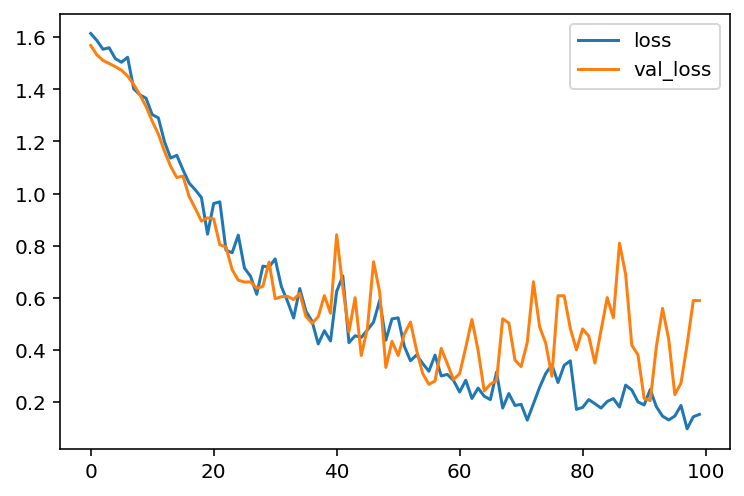

In [16]:
utils.plot_history(history, ['loss', 'val_loss'])

在0.4 之后再训练会出现overfitting的问题

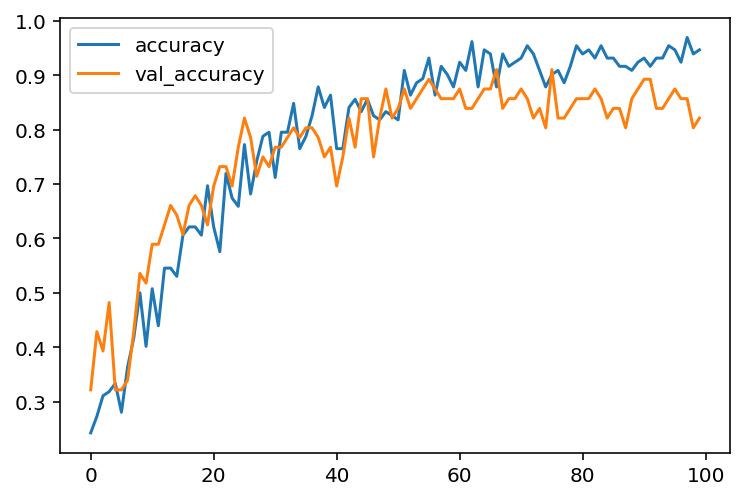

In [28]:
utils.plot_history(history, ['accuracy', 'val_accuracy'])

In [18]:
emoji_model.evaluate(train_x, train_y)
emoji_model.evaluate(test_x, test_y)

132/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.589246677500861, 0.8214286]

### Sava and Load Models

In [19]:
# import
import h5py

Two parts need to be saved inorder to use the model in prod:

1. Neural Network Structure (json)
2. Trained Weights (Matrix) (h5)

We will save them separately. This makes it easy to manage multiple versions of weights and you can always choose which version to go for production.

In [20]:
import os

model_root = 'resources/emoji_model'
os.makedirs(model_root, exist_ok=True)

In [21]:
# Save model structure as json
with open(os.path.join(model_root, "network.json"), "w") as fp:
    fp.write(emoji_model.to_json())

# Save model weights
emoji_model.save_weights(os.path.join(model_root, "weights.h5"))

Download and load a pretrained model 

In [22]:
network_path, weights_path = utils.download_best_emoji_model()

data already available, skip downloading.


In [23]:
from tensorflow.keras.models import model_from_json

# Load model structure
with open(network_path, "r") as fp:
    emoji_model_best = model_from_json(fp.read())

# Load model weights
emoji_model_best.load_weights(weights_path)

In [24]:
emoji_model_best.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

In [25]:
emoji_model_best.evaluate(train_x, train_y)
emoji_model_best.evaluate(test_x, test_y)

132/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.28151012850659235, 0.9285714]

In [26]:
def predict(text):
    x = utils.sentences_to_indices(
        np.array([text]), 
        word_to_index, 
        maxlen)
    
    probs = emoji_model_best.predict(x)
    pred = np.argmax(probs)
    
    print(text, utils.label_to_emoji(pred))

In [27]:
predict('i am not feeling happy') #可以处理单词出现顺序非常重要的情况

i am not feeling happy 😞


## Mission Impossible

<img src="resources/imf.png" width="100px">

Now you've learned all the necessary building blocks for doing sentiment analysis, from the data preprocessing pipeline, the simple NB model, to the SOTA deep LSTM network. Now it's time for you to take a challenge!


Your mission, should you choose to accept it, is to apply what we've learned and apply it to the IMDB dataset. You may write your own script for doing preprocessing, choose any models you like. You may also use any types of word embeddings (`Word2Vec`, `Spacy`, `FastText`), or even character level embeddings! Only the sky is the limit.

The challenge is simple, **boost the accuracy on test dataset to above 90%**, which is 7% higher than our baseline model (MNB). If you make it, it will be a pretty strong indicator to prove that you've understand the data and the pipeline well, knowing where the bottleneck is and how to overcome it. 

As always, should you or any of your IM Force be caught or killed, the Secretary will disavow any knowledge of your actions. This notebook will self-destruct in five minutes. Good luck.

5, 4, 3, 2, 1... No it will not self-destruct, I'm just kidding 😛

### Some hints:

1. Think about what information are missing during preprocessing. (e.g.: checkout `stopwords`)
2. Should we limit the vocabulary even if we're using embedding?
3. If so, how should we handle OOV word?
4. How to choose the number of layers and number of units for LSTM?
5. Need GPU? Colab or FloydHub is your friend! (Though I don't think it will make a real difference on NLP tasks.)

> Please try your best as practice is the only way to understand something. But don't worry too much, I'll post my solution in a week :) 